# Self-Attention GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
4 Convolutional layers, 32 filters multiplier for both generator and discriminator, batch-size 32 images (due to GPU VRAM constraints), 15 epochs (each using the entire CIFAR-10 dataset).

Spectral norm applied to each Convolutional layer in both Generator, and Discriminator, except output layer.

Attention layer is used just after the 32 x 32 Convolutional layer for both Generator and Discriminator.

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import SelfAttention, FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, clean_make_dir, save_best_generator_image, mean_fid

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class SelfAttentionGenerator(tnn.Module):
    def __init__(self, latent_size=100, gen_hidden_units=64):
        super(SelfAttentionGenerator, self).__init__()
        self.attn_layer = SelfAttention(gen_hidden_units)
        self.l1 = tnn.Sequential(
            # Input layer
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(latent_size, out_channels=gen_hidden_units * 8, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 8),
            tnn.ReLU(True)
                )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 8, gen_hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 4, gen_hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units * 2),
            tnn.ReLU(True)
                )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(gen_hidden_units * 2, gen_hidden_units, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(gen_hidden_units),
            tnn.ReLU(True)
                )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(gen_hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.attn_layer(output)
        output = self.lout(output)
        return output

class SelfAttentionDiscriminator(tnn.Module):
    def __init__(self, latent_size=100, dis_hidden_units=64):
        super(SelfAttentionDiscriminator, self).__init__()
        self.num_hidden_units = dis_hidden_units
        self.attn_layer = SelfAttention(dis_hidden_units)
        self.l1 = tnn.Sequential(
                # Input layer
                tnn.utils.spectral_norm(tnn.Conv2d(in_channels=3, out_channels=dis_hidden_units, kernel_size=4, stride=2, padding=1, bias=False)),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l2 = tnn.Sequential(
                # Layer 1
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units, dis_hidden_units * 2, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 2),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l3 = tnn.Sequential(
                # Layer 2
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 2, dis_hidden_units * 4, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 4),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.l4 = tnn.Sequential(
                # Layer 3
                tnn.utils.spectral_norm(tnn.Conv2d(dis_hidden_units * 4, dis_hidden_units * 8, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(dis_hidden_units * 8),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.lout = tnn.Sequential(
                # Output Layer
                tnn.Linear(4 * 4 * 4 * dis_hidden_units, 1, bias=False)
                )
        return

    def forward(self, x):
        output = self.l1(x)
        output = self.attn_layer(output)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = output.view(-1, 4 * 4 * 4 * self.num_hidden_units)
        output = self.lout(output)
        return output

### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/sagan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 30
gen_hidden_units = 32
dis_hidden_units = 32
debug_info       = False
clean_dirs       = True
save_best        = True
log_interval     = 100
fid_batch_interval = 10

### Actual Model Run

21/10/2019 01:55:03 PM - INFO: Clean selected - removing: ./output/sagan
21/10/2019 01:55:03 PM - INFO: Creating output directory: ./output/sagan
21/10/2019 01:55:03 PM - INFO: Dataset path: ./cifar10, Output path: ./output/sagan, Batch Size: 32, Latent Size: 100, Num iterations: 30, Generator unit multiplier: 32, Discriminator unit multiplier: 32, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


21/10/2019 01:55:05 PM - INFO: CUDA enabled device found - will use CUDA device
21/10/2019 01:55:12 PM - INFO: SelfAttentionGenerator(
  (attn_layer): SelfAttention(
    (conv_query): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_key): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_value): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (l1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm

21/10/2019 02:03:53 PM - INFO: Epoch: 4/30, Sample: 501/1562, Disc Loss: 1.7484, Gen Loss: 1.7690
21/10/2019 02:03:59 PM - INFO: Epoch: 4/30, Sample: 601/1562, Disc Loss: 1.8212, Gen Loss: -0.2120
21/10/2019 02:04:05 PM - INFO: Epoch: 4/30, Sample: 701/1562, Disc Loss: 1.5610, Gen Loss: 2.1525
21/10/2019 02:04:11 PM - INFO: Epoch: 4/30, Sample: 801/1562, Disc Loss: 1.2378, Gen Loss: 0.9799
21/10/2019 02:04:17 PM - INFO: Epoch: 4/30, Sample: 901/1562, Disc Loss: 1.3538, Gen Loss: 0.5207
21/10/2019 02:04:23 PM - INFO: Epoch: 4/30, Sample: 1001/1562, Disc Loss: 0.9505, Gen Loss: 1.5714
21/10/2019 02:04:29 PM - INFO: Epoch: 4/30, Sample: 1101/1562, Disc Loss: 2.8729, Gen Loss: 0.8009
21/10/2019 02:04:35 PM - INFO: Epoch: 4/30, Sample: 1201/1562, Disc Loss: 0.6794, Gen Loss: 2.0515
21/10/2019 02:04:41 PM - INFO: Epoch: 4/30, Sample: 1301/1562, Disc Loss: 1.4334, Gen Loss: 0.4957
21/10/2019 02:04:47 PM - INFO: Epoch: 4/30, Sample: 1401/1562, Disc Loss: 0.7336, Gen Loss: 0.7672
21/10/2019 02:

21/10/2019 02:17:40 PM - INFO: Epoch: 9/30, Sample: 501/1562, Disc Loss: 0.8189, Gen Loss: 1.2916
21/10/2019 02:17:46 PM - INFO: Epoch: 9/30, Sample: 601/1562, Disc Loss: 1.3001, Gen Loss: 0.8492
21/10/2019 02:17:52 PM - INFO: Epoch: 9/30, Sample: 701/1562, Disc Loss: 1.1722, Gen Loss: 3.0877
21/10/2019 02:17:58 PM - INFO: Epoch: 9/30, Sample: 801/1562, Disc Loss: 1.4335, Gen Loss: 0.3803
21/10/2019 02:18:04 PM - INFO: Epoch: 9/30, Sample: 901/1562, Disc Loss: 1.4989, Gen Loss: 0.2955
21/10/2019 02:18:10 PM - INFO: Epoch: 9/30, Sample: 1001/1562, Disc Loss: 0.6094, Gen Loss: 4.0095
21/10/2019 02:18:16 PM - INFO: Epoch: 9/30, Sample: 1101/1562, Disc Loss: 0.2374, Gen Loss: 2.2287
21/10/2019 02:18:23 PM - INFO: Epoch: 9/30, Sample: 1201/1562, Disc Loss: 1.5227, Gen Loss: -0.3161
21/10/2019 02:18:29 PM - INFO: Epoch: 9/30, Sample: 1301/1562, Disc Loss: 0.4613, Gen Loss: 1.3032
21/10/2019 02:18:35 PM - INFO: Epoch: 9/30, Sample: 1401/1562, Disc Loss: 0.6717, Gen Loss: 0.2483
21/10/2019 02:

21/10/2019 02:31:34 PM - INFO: Epoch: 14/30, Sample: 501/1562, Disc Loss: 1.4280, Gen Loss: 1.6726
21/10/2019 02:31:40 PM - INFO: Epoch: 14/30, Sample: 601/1562, Disc Loss: 0.3265, Gen Loss: 2.6295
21/10/2019 02:31:46 PM - INFO: Epoch: 14/30, Sample: 701/1562, Disc Loss: 0.4499, Gen Loss: 1.0356
21/10/2019 02:31:52 PM - INFO: Epoch: 14/30, Sample: 801/1562, Disc Loss: 0.5357, Gen Loss: 2.2159
21/10/2019 02:31:58 PM - INFO: Epoch: 14/30, Sample: 901/1562, Disc Loss: 0.3512, Gen Loss: 2.6830
21/10/2019 02:32:04 PM - INFO: Epoch: 14/30, Sample: 1001/1562, Disc Loss: 0.5902, Gen Loss: 1.1021
21/10/2019 02:32:11 PM - INFO: Epoch: 14/30, Sample: 1101/1562, Disc Loss: 0.7524, Gen Loss: 0.6096
21/10/2019 02:32:17 PM - INFO: Epoch: 14/30, Sample: 1201/1562, Disc Loss: 0.3026, Gen Loss: 1.0018
21/10/2019 02:32:23 PM - INFO: Epoch: 14/30, Sample: 1301/1562, Disc Loss: 0.8798, Gen Loss: 0.2582
21/10/2019 02:32:29 PM - INFO: Epoch: 14/30, Sample: 1401/1562, Disc Loss: 1.6779, Gen Loss: 2.1723
21/10

21/10/2019 02:45:30 PM - INFO: Epoch: 19/30, Sample: 501/1562, Disc Loss: 0.3520, Gen Loss: 2.0338
21/10/2019 02:45:36 PM - INFO: Epoch: 19/30, Sample: 601/1562, Disc Loss: 0.5904, Gen Loss: 3.6910
21/10/2019 02:45:42 PM - INFO: Epoch: 19/30, Sample: 701/1562, Disc Loss: 1.0096, Gen Loss: 1.5544
21/10/2019 02:45:48 PM - INFO: Epoch: 19/30, Sample: 801/1562, Disc Loss: 0.2303, Gen Loss: 0.9783
21/10/2019 02:45:54 PM - INFO: Epoch: 19/30, Sample: 901/1562, Disc Loss: 0.8534, Gen Loss: 1.3080
21/10/2019 02:46:00 PM - INFO: Epoch: 19/30, Sample: 1001/1562, Disc Loss: 0.6342, Gen Loss: 3.0382
21/10/2019 02:46:06 PM - INFO: Epoch: 19/30, Sample: 1101/1562, Disc Loss: 0.0000, Gen Loss: 2.1439
21/10/2019 02:46:13 PM - INFO: Epoch: 19/30, Sample: 1201/1562, Disc Loss: 1.2951, Gen Loss: 3.5575
21/10/2019 02:46:19 PM - INFO: Epoch: 19/30, Sample: 1301/1562, Disc Loss: 0.6596, Gen Loss: 3.5780
21/10/2019 02:46:25 PM - INFO: Epoch: 19/30, Sample: 1401/1562, Disc Loss: 0.4974, Gen Loss: 0.8435
21/10

21/10/2019 02:59:24 PM - INFO: Epoch: 24/30, Sample: 501/1562, Disc Loss: 0.2737, Gen Loss: 2.7933
21/10/2019 02:59:30 PM - INFO: Epoch: 24/30, Sample: 601/1562, Disc Loss: 0.7120, Gen Loss: 1.4503
21/10/2019 02:59:36 PM - INFO: Epoch: 24/30, Sample: 701/1562, Disc Loss: 0.7579, Gen Loss: 2.3715
21/10/2019 02:59:41 PM - INFO: Epoch: 24/30, Sample: 801/1562, Disc Loss: 0.0967, Gen Loss: 1.7402
21/10/2019 02:59:47 PM - INFO: Epoch: 24/30, Sample: 901/1562, Disc Loss: 0.6289, Gen Loss: 2.3858
21/10/2019 02:59:53 PM - INFO: Epoch: 24/30, Sample: 1001/1562, Disc Loss: 0.0000, Gen Loss: 1.8102
21/10/2019 02:59:59 PM - INFO: Epoch: 24/30, Sample: 1101/1562, Disc Loss: 0.7229, Gen Loss: 3.2594
21/10/2019 03:00:05 PM - INFO: Epoch: 24/30, Sample: 1201/1562, Disc Loss: 0.7015, Gen Loss: 1.1070
21/10/2019 03:00:11 PM - INFO: Epoch: 24/30, Sample: 1301/1562, Disc Loss: 0.2348, Gen Loss: 2.5733
21/10/2019 03:00:17 PM - INFO: Epoch: 24/30, Sample: 1401/1562, Disc Loss: 0.4767, Gen Loss: 2.3264
21/10

21/10/2019 03:13:05 PM - INFO: Epoch: 29/30, Sample: 501/1562, Disc Loss: 0.0855, Gen Loss: 2.4468
21/10/2019 03:13:11 PM - INFO: Epoch: 29/30, Sample: 601/1562, Disc Loss: 0.3720, Gen Loss: 0.9319
21/10/2019 03:13:17 PM - INFO: Epoch: 29/30, Sample: 701/1562, Disc Loss: 0.1362, Gen Loss: 1.9055
21/10/2019 03:13:23 PM - INFO: Epoch: 29/30, Sample: 801/1562, Disc Loss: 0.2721, Gen Loss: 3.3804
21/10/2019 03:13:29 PM - INFO: Epoch: 29/30, Sample: 901/1562, Disc Loss: 0.0442, Gen Loss: 2.5042
21/10/2019 03:13:35 PM - INFO: Epoch: 29/30, Sample: 1001/1562, Disc Loss: 0.5274, Gen Loss: 2.1051
21/10/2019 03:13:41 PM - INFO: Epoch: 29/30, Sample: 1101/1562, Disc Loss: 0.1211, Gen Loss: 1.1307
21/10/2019 03:13:47 PM - INFO: Epoch: 29/30, Sample: 1201/1562, Disc Loss: 0.9291, Gen Loss: 3.5185
21/10/2019 03:13:53 PM - INFO: Epoch: 29/30, Sample: 1301/1562, Disc Loss: 0.1675, Gen Loss: 0.2106
21/10/2019 03:13:59 PM - INFO: Epoch: 29/30, Sample: 1401/1562, Disc Loss: 0.1166, Gen Loss: 6.2748
21/10

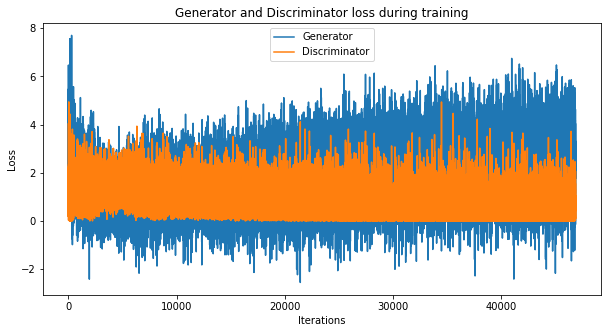

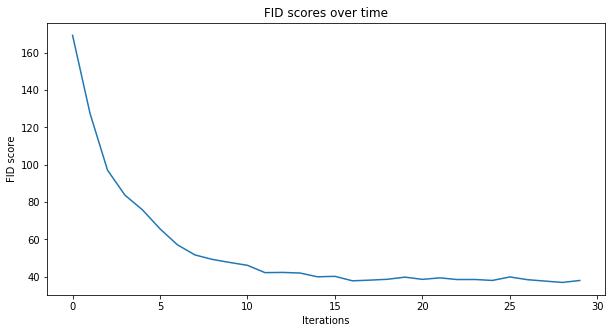

In [4]:
if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = SelfAttentionGenerator(latent_size=latent_size, gen_hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = SelfAttentionDiscriminator(latent_size=latent_size, dis_hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

noise = t.randn(batch_size, latent_size, 1, 1, device=device)

# Discriminator and Generator should have different learning rates
dis_optimizer = toptimizer.Adam(discriminator.parameters(), lr=learning_rate*4, betas=(0.5, 0.999))
gen_optimizer = toptimizer.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # DISCRIMINATOR
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        # Batch size
        bs = real_images.size(0)

        output = discriminator(real_images)
        # Hinge loss
        dis_err_real = F.relu(1.0 - output).mean()
        # Discriminator output mean for real images
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise)
        # Discriminator output for fake images
        output = discriminator(fake_images.detach())
        # Hinge loss
        dis_err_fake = F.relu(1.0 + output).mean()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = dis_err_real + dis_err_fake
        discriminator.zero_grad()
        dis_err.backward()
        dis_optimizer.step()

        # GENERATOR
        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(epoch_noise)
        # Test discriminator again - this time after training it
        output = discriminator(fake_images)
        # Hinge loss
        gen_err = - output.mean()
        generator.zero_grad()
        gen_err.backward()
        # Discriminator output mean for fake images - after discriminator update
        D_G_z2 = output.mean().item()
        gen_optimizer.step()

        gen_losses.append(gen_err.item())
        dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 200 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(noise)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)
        
        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Save attention map
    tutils.save_image(discriminator.attn_layer.get_attention(as_image=True), "{0}/discriminator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)
    tutils.save_image(generator.attn_layer.get_attention(as_image=True), "{0}/generator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, _ = next(testing_data_iter)
            r_im.to(device=device)
            if real_image_batch is None:
                real_image_batch = r_im
            else:
                real_image_batch = t.cat((real_image_batch, r_im), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

In [5]:
if save_best:
    save_best_generator_image(generator, gen_filenames, fid_scores, noise, output_path)

21/10/2019 03:18:05 PM - INFO: Generator model with lowest FID score is ./output/sagan/generator_epoch_29.pth
21/10/2019 03:18:05 PM - INFO: Saving output of best generator model to ./output/sagan/best_fake_sample.png


21/10/2019 03:18:05 PM - INFO: Last image generated


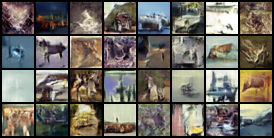

21/10/2019 03:18:05 PM - INFO: Image generated from model with lowest FID score


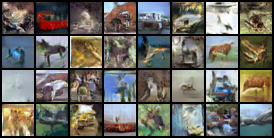

In [6]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))